# salvo_compare_models

Notebook for loading and comparing albedo evolution with models

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import warnings

from modules.salvoimport import load_salvo_data_str, load_gml_albedo, preprocess_rap
from modules.salvoproc import line_date_agg

%load_ext autoreload
%autoreload 2

In [2]:
# Set matplotlib font parameters
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}

mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] = 2

## Load data

In [3]:
# Load SALVO data
salvo_data_root_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                                    "SALVO", "data", "salvo-2024-backup", "SALVO-2024-20240619-1305")

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df = load_salvo_data_str(salvo_data_root_path, dates=None,insts=['kz-mobile', 'magnaprobe'], sites=['arm', 'beo', 'ice'])

In [4]:
# Load NSA qcrad data
nsa_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "nsaqcrad", "*.cdf")
ds_nsa = xr.open_mfdataset(nsa_path)
varnames = ['BestEstimate_down_short_hemisp', 'up_short_hemisp',
            'down_long_hemisp', 'up_long_hemisp',
            'Temp_Air', 'wind_speed']
da_list = []
for varname in varnames:
    da_list.append(ds_nsa[varname].where(ds_nsa['qc_'+varname]==0))
df_nsa = xr.merge(da_list).to_dataframe()
df_nsa['timestamp_utc'] = df_nsa.index.tz_localize('UTC')
df_nsa.set_index('timestamp_utc', inplace=True)
df_nsa['albedo'] = df_nsa['up_short_hemisp']/df_nsa['BestEstimate_down_short_hemisp']

In [5]:
# Load GML
dir_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "gml_albedo_rack")
df_gml = load_gml_albedo(dir_path)

df_gml['incident_bestestimate_W_m2'] = df_gml['direct_solar_W_m2']*np.cos(df_gml['zen']*np.pi/180) + df_gml['diffuse_solar_W_m2']
df_gml['incident_bestestimate_W_m2_qc'] = df_gml['direct_solar_W_m2_qc'] + df_gml['diffuse_solar_W_m2_qc']
df_gml['albedo'] = df_gml['reflected_solar_W_m2'] / df_gml['incident_bestestimate_W_m2']
df_gml['diffuse_frac'] = df_gml['diffuse_solar_W_m2']/df_gml['incident_bestestimate_W_m2']

In [7]:
# Load RAP
dir_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "rap")
#filename = "profiler_sitesF.ncep_rap.2024150.2100.nc"
#ds_rap = xr.open_dataset(os.path.join(dir_path, filename))
#utq_lon = -156.8
#utq_lat = 71.29
#print(np.abs(ds_rap.mlon-utq_lon).argmin())
#print(np.abs(ds_rap.mlat-utq_lat).argmin())

filename = "profiler_sitesF.ncep_rap.202413*.2100.nc"
ds_rap130 = xr.open_mfdataset(os.path.join(dir_path, filename), preprocess=preprocess_rap,
                          combine="nested")
filename = "profiler_sitesF.ncep_rap.202414*.2100.nc"
ds_rap140 = xr.open_mfdataset(os.path.join(dir_path, filename), preprocess=preprocess_rap,
                          combine="nested")
filename = "profiler_sitesF.ncep_rap.202415*.2100.nc"
ds_rap150 = xr.open_mfdataset(os.path.join(dir_path, filename), preprocess=preprocess_rap,
                          combine="nested")
filename = "profiler_sitesF.ncep_rap.202416*.2100.nc"
ds_rap160 = xr.open_mfdataset(os.path.join(dir_path, filename), preprocess=preprocess_rap,
                          combine="nested")
filename = "profiler_sitesF.ncep_rap.202417*.2100.nc"
ds_rap170 = xr.open_mfdataset(os.path.join(dir_path, filename), preprocess=preprocess_rap,
                          combine="nested")

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ds_rap = xr.combine_nested([ds_rap130, ds_rap140, ds_rap150, ds_rap160, ds_rap170], 'model_initialization')

ds_rap['albedo'] = ds_rap['uswsfc0'] / ds_rap['dswsfc0']
ds_rap = ds_rap.compute()

C:\Users\dclemenssewall\.conda\envs\basic_plotting\Lib\site-packages\dask\core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [9]:
# Load ERA5
dir_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "era5")

filename = 'utq.nswrf.sfc.2024.nc'
da_era5_nswrf = xr.open_dataset(os.path.join(dir_path, filename))
filename = 'utq.dswrf.sfc.2024.nc'
da_era5_dswrf = xr.open_dataset(os.path.join(dir_path, filename))
filename = 'utq.albedo.snow.2024.nc'
da_era5_albsno = xr.open_dataset(os.path.join(dir_path, filename))
filename = 'utq.air.2m.2024.nc'
da_era5_tair = xr.open_dataset(os.path.join(dir_path, filename))
filename = 'utq.snod.2024.nc'
da_era5_snod = xr.open_dataset(os.path.join(dir_path, filename))

In [10]:
ds_era5 = xr.merge([da_era5_nswrf, da_era5_dswrf, da_era5_albsno, da_era5_tair, da_era5_snod])

In [11]:
ds_era5['sfcalbedo'] = 1 - ds_era5['nswrf']/ds_era5['dswrf']

In [12]:
# Load CAFS output
cafs_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "CAFS", "Utqiagvik_h0_lnd.nc")
ds_cafs = xr.load_dataset(cafs_path)
df_cafs = ds_cafs[['FSDS', 'FSNO_EFF', 'FSR', 'SNOWDP', 'SNOW_DEPTH', 'TSA', 'FLDS', 'TG', 'FSH', 'EFLX_LH_TOT']].squeeze().to_dataframe()
df_cafs['timestamp_utc'] = df_cafs.index.tz_localize('UTC')
df_cafs.set_index('timestamp_utc', inplace=True)
df_cafs['albedo'] = df_cafs['FSR']/df_cafs['FSDS']

## Plot comparison figure

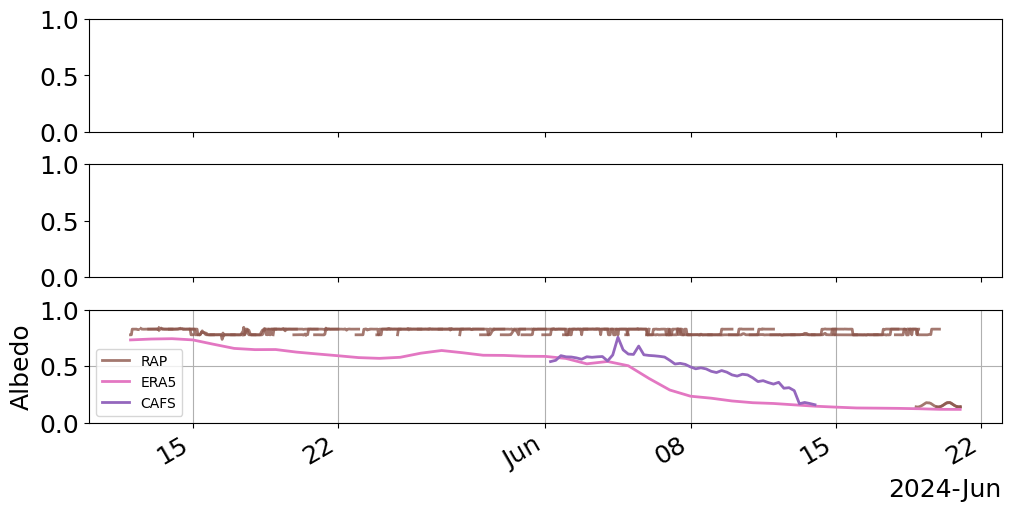

In [24]:
start_date = pd.Timestamp('2024-05-12T00:00:00')
end_date = pd.Timestamp('2024-06-21T00:00:00')

f, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 5), constrained_layout=True)

# Albedo
# RAP
var_name = 'albedo'
da_temp = ds_rap[var_name].sel(time=slice(start_date, end_date))
rap_hdls = axs[2].plot(da_temp['time'].values, da_temp.values.T, c='tab:brown', alpha=0.8)
# ERA5
era_hdl = ds_era5['sfcalbedo'].sel(lon=203.25, time=slice(start_date, end_date)).plot(ax=axs[2], c='tab:pink')
axs[2].set_title('')
# CAFS
df_temp = df_cafs['albedo']
df_temp = df_temp.reset_index()
caf_hdl = axs[2].plot('timestamp_utc', 'albedo', data=df_temp, c='tab:purple', label='CAFS')

axs[2].set_ylabel('Albedo')
axs[2].set_ylim([0, 1])
axs[2].grid()
axs[2].legend(handles=[rap_hdls[0], era_hdl[0], caf_hdl[0]], labels=['RAP', 'ERA5', 'CAFS'],
             fontsize=10)

locator = mdates.AutoDateLocator(minticks=10, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
axs[2].xaxis.set_major_locator(locator)
axs[2].xaxis.set_major_formatter(formatter)

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')

f.savefig(os.path.join('..', 'figures', 'uaf_model_comp_0.png'), bbox_inches='tight')

plt.show()

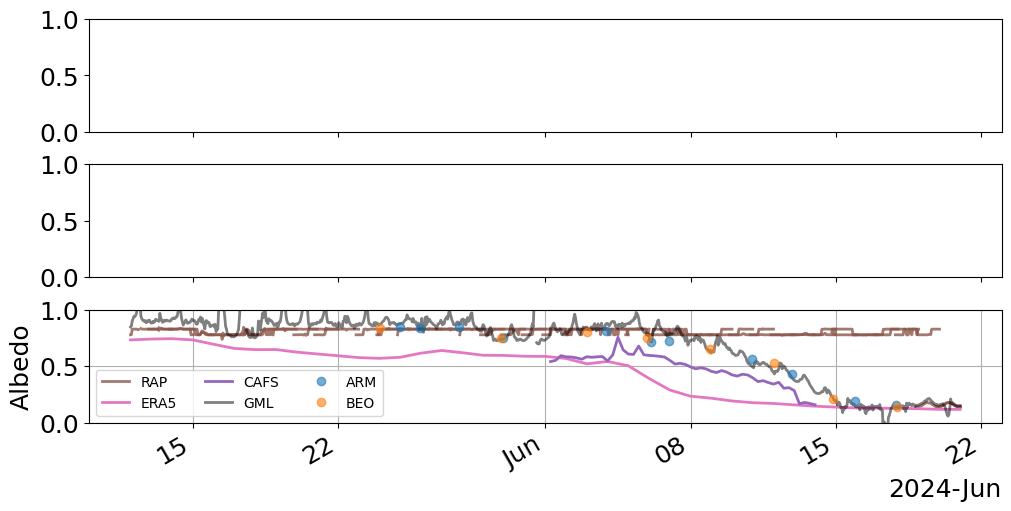

In [25]:
# Now with observed data on top

start_date = pd.Timestamp('2024-05-12T00:00:00')
end_date = pd.Timestamp('2024-06-21T00:00:00')
start_date_utc = pd.Timestamp('2024-05-12T00:00:00+0000')
end_date_utc = pd.Timestamp('2024-06-21T00:00:00+0000')

f, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 5), constrained_layout=True)

# Albedo
# RAP
var_name = 'albedo'
da_temp = ds_rap[var_name].sel(time=slice(start_date, end_date))
rap_hdls = axs[2].plot(da_temp['time'].values, da_temp.values.T, c='tab:brown', alpha=0.8)
# ERA5
era_hdl = ds_era5['sfcalbedo'].sel(lon=203.25, time=slice(start_date, end_date)).plot(ax=axs[2], c='tab:pink')
axs[2].set_title('')
# CAFS
df_temp = df_cafs['albedo']
df_temp = df_temp.reset_index()
caf_hdl = axs[2].plot('timestamp_utc', 'albedo', data=df_temp, c='tab:purple', label='CAFS')
# GML
df_temp = df_gml.query("(incident_bestestimate_W_m2_qc==0) and (reflected_solar_W_m2_qc==0)"
                      ).loc[slice(start_date_utc, end_date_utc)]
df_temp = df_temp['albedo'].resample('1h').mean()
df_temp = df_temp.reset_index()
gml_hdl = axs[2].plot('timestamp_utc', 'albedo', data=df_temp, c='k', alpha=0.5)
# SALVO
df_temp = line_date_agg(df, 'albedo')
df_temp = df_temp.query('position != -999.0')
df_temp = df_temp.groupby(['site', 'date_akdt']).mean()
site = 'arm'
arm_hdl = axs[2].plot('meantime_akdt', 'albedo', 
            data=df_temp.xs(site, level='site').loc[slice(start_date, end_date)],
            c='tab:blue', ls='', marker='o', alpha=0.6)
site = 'beo'
beo_hdl = axs[2].plot('meantime_akdt', 'albedo', 
            data=df_temp.xs(site, level='site').loc[slice(start_date, end_date)],
            c='tab:orange', ls='', marker='o', alpha=0.6)

axs[2].set_ylabel('Albedo')
axs[2].set_ylim([0, 1])
axs[2].grid()
axs[2].legend(handles=[rap_hdls[0], era_hdl[0], caf_hdl[0], gml_hdl[0], 
                       arm_hdl[0], beo_hdl[0]], 
                       labels=['RAP', 'ERA5', 'CAFS', 'GML', 'ARM', 'BEO'],
             fontsize=10, ncols=3)

locator = mdates.AutoDateLocator(minticks=10, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
axs[2].xaxis.set_major_locator(locator)
axs[2].xaxis.set_major_formatter(formatter)

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')

f.savefig(os.path.join('..', 'figures', 'uaf_model_comp_1.png'), bbox_inches='tight')

plt.show()

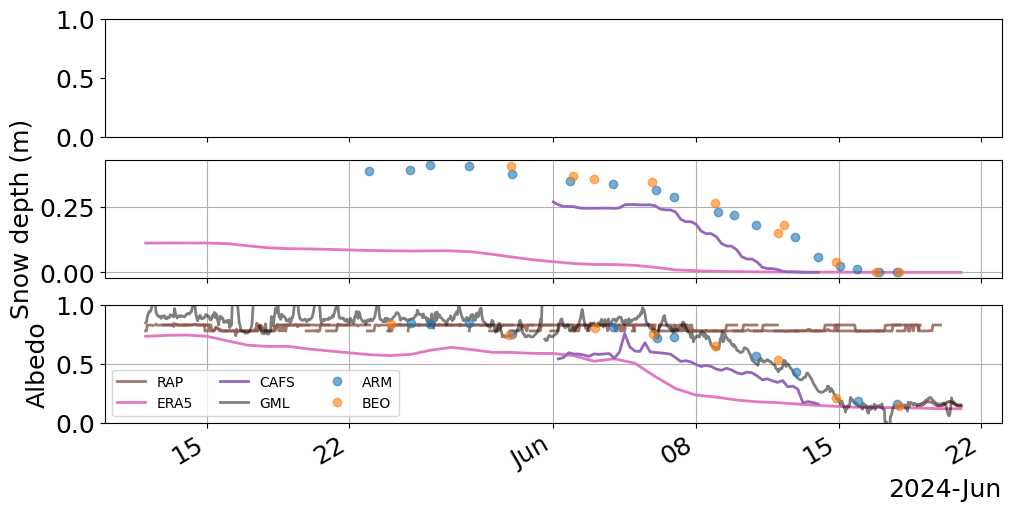

In [26]:
# Add snow data

start_date = pd.Timestamp('2024-05-12T00:00:00')
end_date = pd.Timestamp('2024-06-21T00:00:00')
start_date_utc = pd.Timestamp('2024-05-12T00:00:00+0000')
end_date_utc = pd.Timestamp('2024-06-21T00:00:00+0000')

f, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 5), constrained_layout=True)

# Snow Depth
# Albedo
# ERA5
era_hdl = ds_era5['snod'].sel(lon=203.25, time=slice(start_date, end_date)).plot(ax=axs[1], c='tab:pink')
axs[1].set_title('')
# CAFS
df_temp = df_cafs['SNOWDP']
df_temp = df_temp.reset_index()
caf_hdl = axs[1].plot('timestamp_utc', 'SNOWDP', data=df_temp, c='tab:purple', label='CAFS')
# SALVO
df_temp = line_date_agg(df, 'snow_depth_m')
df_temp = df_temp.query('position != -999.0')
df_temp = df_temp.groupby(['site', 'date_akdt']).mean()
site = 'arm'
arm_hdl = axs[1].plot('meantime_akdt', 'snow_depth_m', 
            data=df_temp.xs(site, level='site').loc[slice(start_date, end_date)],
            c='tab:blue', ls='', marker='o', alpha=0.6)
site = 'beo'
beo_hdl = axs[1].plot('meantime_akdt', 'snow_depth_m', 
            data=df_temp.xs(site, level='site').loc[slice(start_date, end_date)],
            c='tab:orange', ls='', marker='o', alpha=0.6)

axs[1].set_ylabel('Snow depth (m)')
#axs[2].set_ylim([0, 1])
axs[1].grid()


# Albedo
# RAP
var_name = 'albedo'
da_temp = ds_rap[var_name].sel(time=slice(start_date, end_date))
rap_hdls = axs[2].plot(da_temp['time'].values, da_temp.values.T, c='tab:brown', alpha=0.8)
# ERA5
era_hdl = ds_era5['sfcalbedo'].sel(lon=203.25, time=slice(start_date, end_date)).plot(ax=axs[2], c='tab:pink')
axs[2].set_title('')
# CAFS
df_temp = df_cafs['albedo']
df_temp = df_temp.reset_index()
caf_hdl = axs[2].plot('timestamp_utc', 'albedo', data=df_temp, c='tab:purple', label='CAFS')
# GML
df_temp = df_gml.query("(incident_bestestimate_W_m2_qc==0) and (reflected_solar_W_m2_qc==0)"
                      ).loc[slice(start_date_utc, end_date_utc)]
df_temp = df_temp['albedo'].resample('1h').mean()
df_temp = df_temp.reset_index()
gml_hdl = axs[2].plot('timestamp_utc', 'albedo', data=df_temp, c='k', alpha=0.5)
# SALVO
df_temp = line_date_agg(df, 'albedo')
df_temp = df_temp.query('position != -999.0')
df_temp = df_temp.groupby(['site', 'date_akdt']).mean()
site = 'arm'
arm_hdl = axs[2].plot('meantime_akdt', 'albedo', 
            data=df_temp.xs(site, level='site').loc[slice(start_date, end_date)],
            c='tab:blue', ls='', marker='o', alpha=0.6)
site = 'beo'
beo_hdl = axs[2].plot('meantime_akdt', 'albedo', 
            data=df_temp.xs(site, level='site').loc[slice(start_date, end_date)],
            c='tab:orange', ls='', marker='o', alpha=0.6)

axs[2].set_ylabel('Albedo')
axs[2].set_ylim([0, 1])
axs[2].grid()
axs[2].legend(handles=[rap_hdls[0], era_hdl[0], caf_hdl[0], gml_hdl[0], 
                       arm_hdl[0], beo_hdl[0]], 
                       labels=['RAP', 'ERA5', 'CAFS', 'GML', 'ARM', 'BEO'],
             fontsize=10, ncols=3)

locator = mdates.AutoDateLocator(minticks=10, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
axs[2].xaxis.set_major_locator(locator)
axs[2].xaxis.set_major_formatter(formatter)

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')

f.savefig(os.path.join('..', 'figures', 'uaf_model_comp_2.png'), bbox_inches='tight')

plt.show()

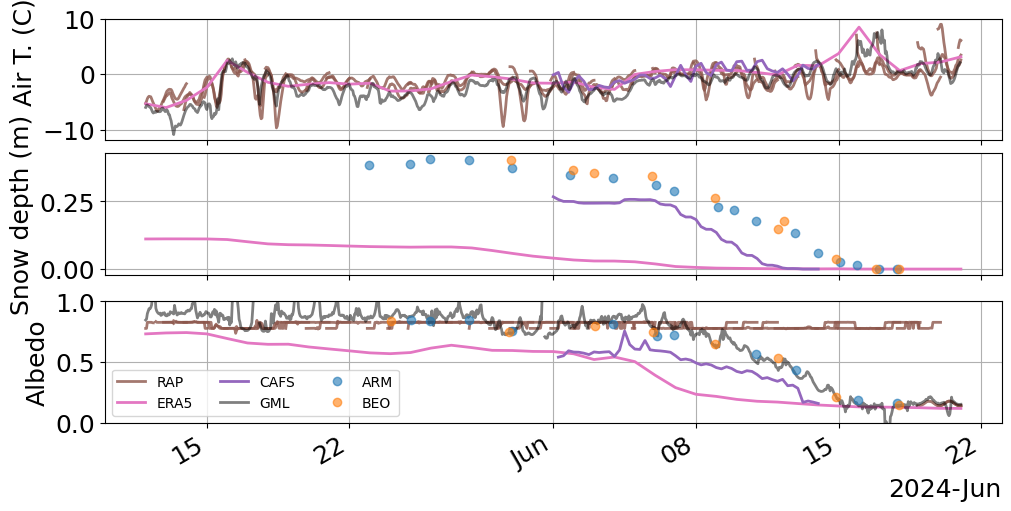

In [32]:
# Add air temperature data

start_date = pd.Timestamp('2024-05-12T00:00:00')
end_date = pd.Timestamp('2024-06-21T00:00:00')
start_date_utc = pd.Timestamp('2024-05-12T00:00:00+0000')
end_date_utc = pd.Timestamp('2024-06-21T00:00:00+0000')

f, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 5), constrained_layout=True)

# Air temperature
# RAP
var_name = 'tsfc0'
da_temp = ds_rap[var_name].sel(time=slice(start_date, end_date))
rap_hdls = axs[0].plot(da_temp['time'].values, da_temp.values.T, c='tab:brown', alpha=0.8)
# ERA5
era_hdl = (ds_era5['air'].sel(lon=203.25, time=slice(start_date, end_date))-273.15).plot(ax=axs[0], c='tab:pink')
axs[0].set_title('')
# CAFS
df_temp = df_cafs['TSA']-273.15
df_temp = df_temp.reset_index()
caf_hdl = axs[0].plot('timestamp_utc', 'TSA', data=df_temp, c='tab:purple', label='CAFS')
# GML
df_temp = df_gml.query("air_temp_C_qc==0").loc[slice(start_date_utc, end_date_utc)]
df_temp = df_temp['air_temp_C'].resample('1h').mean()
df_temp = df_temp.reset_index()
gml_hdl = axs[0].plot('timestamp_utc', 'air_temp_C', data=df_temp, c='k', alpha=0.5)

axs[0].set_ylabel('       Air T. (C)')
axs[0].grid()

# Snow Depth
# Albedo
# ERA5
era_hdl = ds_era5['snod'].sel(lon=203.25, time=slice(start_date, end_date)).plot(ax=axs[1], c='tab:pink')
axs[1].set_title('')
# CAFS
df_temp = df_cafs['SNOWDP']
df_temp = df_temp.reset_index()
caf_hdl = axs[1].plot('timestamp_utc', 'SNOWDP', data=df_temp, c='tab:purple', label='CAFS')
# SALVO
df_temp = line_date_agg(df, 'snow_depth_m')
df_temp = df_temp.query('position != -999.0')
df_temp = df_temp.groupby(['site', 'date_akdt']).mean()
site = 'arm'
arm_hdl = axs[1].plot('meantime_akdt', 'snow_depth_m', 
            data=df_temp.xs(site, level='site').loc[slice(start_date, end_date)],
            c='tab:blue', ls='', marker='o', alpha=0.6)
site = 'beo'
beo_hdl = axs[1].plot('meantime_akdt', 'snow_depth_m', 
            data=df_temp.xs(site, level='site').loc[slice(start_date, end_date)],
            c='tab:orange', ls='', marker='o', alpha=0.6)

axs[1].set_ylabel('Snow depth (m)')
#axs[2].set_ylim([0, 1])
axs[1].grid()

# Albedo
# RAP
var_name = 'albedo'
da_temp = ds_rap[var_name].sel(time=slice(start_date, end_date))
rap_hdls = axs[2].plot(da_temp['time'].values, da_temp.values.T, c='tab:brown', alpha=0.8)
# ERA5
era_hdl = ds_era5['sfcalbedo'].sel(lon=203.25, time=slice(start_date, end_date)).plot(ax=axs[2], c='tab:pink')
axs[2].set_title('')
# CAFS
df_temp = df_cafs['albedo']
df_temp = df_temp.reset_index()
caf_hdl = axs[2].plot('timestamp_utc', 'albedo', data=df_temp, c='tab:purple', label='CAFS')
# GML
df_temp = df_gml.query("(incident_bestestimate_W_m2_qc==0) and (reflected_solar_W_m2_qc==0)"
                      ).loc[slice(start_date_utc, end_date_utc)]
df_temp = df_temp['albedo'].resample('1h').mean()
df_temp = df_temp.reset_index()
gml_hdl = axs[2].plot('timestamp_utc', 'albedo', data=df_temp, c='k', alpha=0.5)
# SALVO
df_temp = line_date_agg(df, 'albedo')
df_temp = df_temp.query('position != -999.0')
df_temp = df_temp.groupby(['site', 'date_akdt']).mean()
site = 'arm'
arm_hdl = axs[2].plot('meantime_akdt', 'albedo', 
            data=df_temp.xs(site, level='site').loc[slice(start_date, end_date)],
            c='tab:blue', ls='', marker='o', alpha=0.6)
site = 'beo'
beo_hdl = axs[2].plot('meantime_akdt', 'albedo', 
            data=df_temp.xs(site, level='site').loc[slice(start_date, end_date)],
            c='tab:orange', ls='', marker='o', alpha=0.6)

axs[2].set_ylabel('Albedo')
axs[2].set_ylim([0, 1])
axs[2].grid()
axs[2].legend(handles=[rap_hdls[0], era_hdl[0], caf_hdl[0], gml_hdl[0], 
                       arm_hdl[0], beo_hdl[0]], 
                       labels=['RAP', 'ERA5', 'CAFS', 'GML', 'ARM', 'BEO'],
             fontsize=10, ncols=3)

locator = mdates.AutoDateLocator(minticks=10, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
axs[2].xaxis.set_major_locator(locator)
axs[2].xaxis.set_major_formatter(formatter)

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')

f.savefig(os.path.join('..', 'figures', 'uaf_model_comp_3.png'), bbox_inches='tight')

plt.show()

In [31]:
ds_era5

<xarray.Dataset>
Dimensions:    (lat: 1, lon: 2, time: 244, nbnds: 2)
Coordinates:
  * lat        (lat) float64 71.25
  * lon        (lon) float64 203.2 203.5
  * time       (time) datetime64[ns] 2024-01-01 2024-01-02 ... 2024-08-31
Dimensions without coordinates: nbnds
Data variables:
    nswrf      (time, lat, lon) float32 1e-15 1e-15 1e-15 1e-15 ... nan nan nan
    time_bnds  (time, nbnds) float64 1.964e+06 1.964e+06 ... 1.969e+06 1.969e+06
    dswrf      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    albedo     (time, lat, lon) float32 ...
    air        (time, lat, lon) float32 ...
    snod       (time, lat, lon) float32 ...
    sfcalbedo  (time, lat, lon) float32 -inf -inf -inf -inf ... nan nan nan nan
Attributes: (12/26)
    Conventions:               CF-1.6
    title:                     daily mean ERA5 Reanalysis
    comments:                  Obtained at NCAR and converted to PSL NetCDF f...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    license:                   These data can be used at PSL. Do not redistri...
    creator_name:              NOAA/PSL
    ...                        ...
    rda_dataset_doi:           DOI: 10.5065/BH6N-5N20
    rda_dataset_group:         ERA5 atmospheric surface analysis
    grid_specification:        0.25 degree x 0.25 degree from 90N to 90S and ...
    original_source:           ECMWF: https://cds.climate.copernicus.eu, Cope...
    source:                    NCAR, Boulder CO
    NCO:                       netCDF Operators version 4.8.1 (Homepage = htt...